In [ ]:
import numpy as np
import lib.io.stan

np.random.seed(0)
ntwrk = np.load('results/exp10/AC_network.npz')
SC = ntwrk['SC']
gain = ntwrk['gain_mat']
sim_data_6d = np.load('results/exp10/AC_syn_tvb_ez=59_pz=82-74.npz')

nn = SC.shape[0]
ns  = gain.shape[0]
nt = 10000
I1 = 3.1
tau0 = 1600.0
x0 = sim_data_6d['x0']
time_scale = 1.0
time_step = 0.5
sigma = 0.01
k = 1.0
epsilon = 0.01
x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(size = (nt-1, nn))

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain':gain,
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step, 'sigma':sigma,
        'k':k, 'epsilon':epsilon, 'x_init':x_init, 'z_init':z_init, 'z_eta':z_eta}

lib.io.stan.rdump('./tmp/tmp.R',data)

! /home/anirudhnihalani/scripts/stancompile.sh vep-forwardsim-2Depileptor

! ./vep-forwardsim-2Depileptor sample num_warmup=0 num_samples=1 algorithm=fixed_param data file='tmp/tmp.R' output file='tmp/tmp.csv'

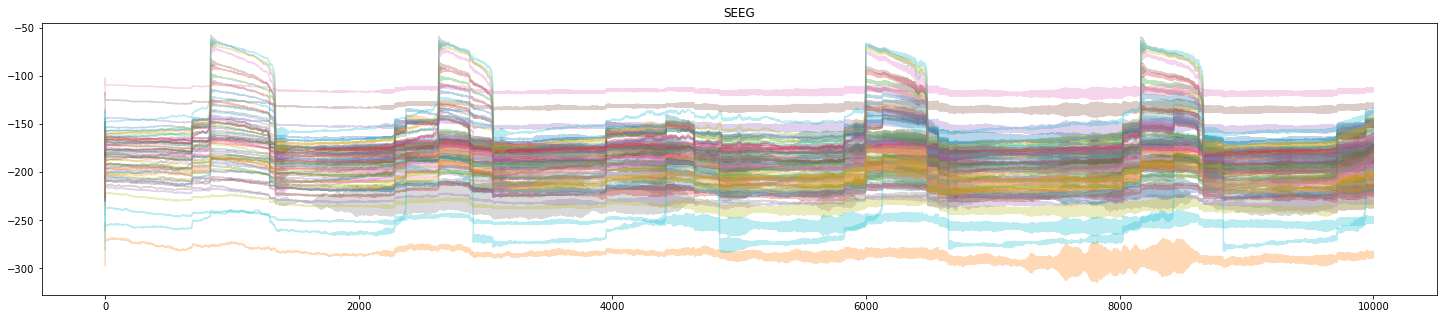

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import lib.io.stan
import numpy as np

sim_out = lib.io.stan.read_samples('tmp/tmp.csv',0,1,ignore_warmup=True)

# plt.figure(figsize=(25,10))
# plt.plot(sim_out['x'][0,3500:5000,],'k');
# plt.title('source signal(x)')

plt.figure(figsize=(25,5))
plt.plot(sim_out['mu_seeg_log_power'][0,...],alpha=0.3);
plt.title('SEEG')